# 🥱 LangGraph 篇_翻譯代理人

## 簡介
歡迎來到這個 Colab 筆記本，我們將展示來自 [Andrew/Translation-Agent](https://github.com/andrewyng/translation-agent) 專案中的翻譯函數。本筆記本將引導您了解翻譯過程中的主要功能，並為每個功能提供詳細的解釋和範例。

本專案旨在促進使用各種語言模型和技術進行文本翻譯的過程。它包括文本分割、翻譯、反思和改進等工具，並將它們整合成一個流暢的工作流程。

在本筆記本中，您將學到：

- 文本分割：如何將大文本分割成可管理的塊進行翻譯。
- 翻譯：如何翻譯單個文本塊。
- 反思：如何反思翻譯並提供建設性反饋。
- 翻譯改進：如何根據反饋改進翻譯。


每個功能將配有詳細的代碼和註釋，幫助您了解其用途和使用方法。通過本筆記本的學習，您將全面了解這些函數如何協同工作以實現高質量的翻譯。

## 更多資源
如果你好奇什麼是 LangGraph 的話，可以參考以下教學資源
- [LangGraph 篇 快速入門教學](https://colab.research.google.com/drive/1orzniNOFi3TZBHfWzntXmI1NN3C9WfIE?usp=sharing)
- [LangGraph 翻譯助手](https://colab.research.google.com/drive/1BbyBVJ_sW_ZlOyiR4Y_Nl6X_W8pYxvmJ?usp=sharing)
- [LangGraph- 會議摘要助手](https://colab.research.google.com/drive/15smWpcUdr3dSxmQR1Ea_Kk3obSUKpke-?usp=sharing)

❤️ Created by [hengshiousheu](https://huggingface.co/Heng666).

# 環境建置

## 安裝套件包

在本演練中，

我們將使用以下套件：

In [ ]:
%pip install --upgrade --quiet langchain==0.2.10
%pip install --upgrade --quiet langchain-openai==0.1.17
%pip install --upgrade --quiet langgraph==0.1.9

我們需要設置 環境變數 `OPENAI_API_KEY` ，可以直接完成，如下所示：

In [ ]:
import os
import getpass
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

### (可用可不用)LangSmith

你用LangChain構建的許多應用程式將包含多個步驟，並多次調用LLM調用。隨著這些應用程式變得越來越複雜，能夠檢查您的鏈或代理內部到底發生了什麼變得至關重要。最好的方法是與[LangSmith](https://smith.langchain.com)合作。

請注意，LangSmith 不是必需的，但它很有説明。如果您確實想使用 LangSmith，請在上面的鏈接中註冊后，請確保設置環境變數以開始記錄跟蹤：

In [ ]:
import os
import getpass
from datetime import datetime
import pytz

current_time = datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d %Z")

os.environ["LANGCHAIN_TRACING_V2"] = "false" ##想要使用記得改 true, 不要時改 false.
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = f"LangGraph 翻譯助手-{current_time}"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

開始設計

## 建立狀態

In [ ]:
from typing import List, Optional
from pydantic import BaseModel, Field

class TranslationState(BaseModel):
    source_lang: str
    target_lang: str
    country: Optional[str] = None
    source_text: str
    source_chunks: List[str] = Field(default_factory=list)
    initial_translation: Optional[str] = None
    initial_translation_chunks: List[str] = Field(default_factory=list)
    reflection: Optional[str] = None
    reflection_chunks: List[str] = Field(default_factory=list)
    final_translation: Optional[str] = None
    final_translation_chunks: List[str] = Field(default_factory=list)

## 建立節點

#### 產生 Completion, 計算 Size
這些函數主要用於處理文本生成和標記計數，特別適合需要分割和管理長文本的情境。通過理解這些函數的參數和返回值，新進人員可以更好地應用它們來實現相關功能，並根據需要進行調整和擴展。

In [ ]:
import openai
from tiktoken import get_encoding
from langchain_text_splitters import RecursiveCharacterTextSplitter

MAX_TOKENS_PER_CHUNK = 1000

def get_completion(prompt: str, system_message: str = "You are a helpful assistant.", model: str = "gpt-4-turbo", temperature: float = 0.3):
    """
    使用 OpenAI API 生成回應。此函數使用 OpenAI API 根據提供的提示和系統消息生成回應。模型和溫度參數可以調整以控制回應的風格和隨機性。

    參數：
        prompt (str): 用戶的提示或查詢。
        system_message (str): 設定助理上下文的系統消息。
        model (str): 使用的 OpenAI 模型名稱。
        temperature (float): 控制隨機性的取樣溫度。

    返回：
        str: 生成的回應。
    """
    response = openai.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_message},
            {"role": "user", "content": prompt}
        ],
        temperature=temperature
    )
    return response.choices[0].message.content

def num_tokens_in_string(input_str: str, encoding_name: str = "cl100k_base") -> int:
    """
    使用指定的編碼計算字串中的標記數量。此函數使用指定的編碼計算並返回輸入字串中的標記數量，這對於分割文本和控制上下文長度很有用。

    參數：
        input_str (str): 要進行標記化的輸入字串。
        encoding_name (str): 使用的編碼名稱。

    返回：
        int: 輸入字串中的標記數量。
    """
    encoding = get_encoding(encoding_name)
    return len(encoding.encode(input_str))

def calculate_chunk_size(token_count: int, token_limit: int) -> int:
    """
    根據標記數量和標記限制計算塊大小。此函數根據總標記數量和每塊允許的最大標記數量計算適當的塊大小。它確保每個塊的大小在限制內，並適當分配剩餘的標記數量。

    參數：
        token_count (int): 總標記數量。
        token_limit (int): 每個塊允許的最大標記數量。

    返回：
        int: 計算出的塊大小。
    """
    if token_count <= token_limit:
        return token_count

    num_chunks = (token_count + token_limit - 1) // token_limit
    chunk_size = token_count // num_chunks

    remaining_tokens = token_count % token_limit
    if remaining_tokens > 0:
        chunk_size += remaining_tokens // num_chunks

    return chunk_size

#### 建立：Text_Splitter Node

此函數的主要用途是處理源文本，將其拆分成適當大小的塊，以便進行後續的翻譯處理。具體步驟如下：

1. **計算源文本中的標記數量：**
使用 num_tokens_in_string 函數計算源文本的標記數量。

2. **判斷是否需要拆分：**
如果標記數量小於預定的最大允許標記數（MAX_TOKENS_PER_CHUNK），則不進行拆分，直接將源文本作為一個整體塊。

3. **計算塊大小並進行拆分：**
如果標記數量超過最大允許標記數，則使用 calculate_chunk_size 函數計算每個塊的標記大小。然後，創建一個遞歸字符文本拆分器（RecursiveCharacterTextSplitter），並使用它將源文本拆分成多個塊。

4. **更新翻譯狀態：**
將拆分後的文本塊存儲到翻譯狀態的 source_chunks 屬性中，並返回更新後的翻譯狀態。

In [ ]:
# text_splitter_node
def text_splitter_node(state: TranslationState) -> TranslationState:
    """
    根據需要將源文本拆分成塊。此函數根據源文本的標記數量，將源文本拆分成適當大小的塊。如果標記數量少於最大允許標記數，則不進行拆分。否則，根據計算出的塊大小進行拆分，並更新翻譯狀態中的源文本塊。

    參數：
        state (TranslationState): 當前的翻譯狀態。

    返回：
        TranslationState: 更新後的翻譯狀態。
    """
    # 計算源文本中的標記數量
    num_tokens = num_tokens_in_string(state.source_text)

    # 如果標記數量小於最大允許標記數，則不進行拆分
    if num_tokens < MAX_TOKENS_PER_CHUNK:
        state.source_chunks = [state.source_text]
    else:
        # 計算每個塊的標記大小
        token_size = calculate_chunk_size(num_tokens, MAX_TOKENS_PER_CHUNK)

        # 創建一個遞歸字符文本拆分器
        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
            model_name="gpt-4",
            chunk_size=token_size,
            chunk_overlap=0,
        )

        # 將源文本拆分成多個塊
        state.source_chunks = text_splitter.split_text(state.source_text)

    return state

#### 建立 translate_single_chunk

此函數的主要用途是對單個文本塊進行翻譯，具體步驟如下：

1. **設置系統消息：**
使用源語言和目標語言設置系統消息，描述翻譯專家的背景。這有助於語言模型在生成翻譯時考慮到專業背景。

2. **設置翻譯提示：**
根據源語言和目標語言設置翻譯提示。提示中明確要求只提供翻譯，不需要任何解釋或附加文本。

3. **生成翻譯：**
使用 get_completion 函數生成翻譯，將生成的翻譯結果存儲在翻譯狀態的 initial_translation 屬性中。

4. **返回更新後的翻譯狀態：**
返回包含初步翻譯結果的更新翻譯狀態。

這個函數是翻譯過程的核心部分，確保每個文本塊能夠準確且高效地被翻譯。通過理解這些步驟，新進人員可以更好地應用和擴展此函數來處理不同的翻譯需求。

In [ ]:
def single_chunk_translation_node(state: TranslationState) -> TranslationState:
    """
    翻譯單個文本塊。

    參數：
        state (TranslationState): 當前的翻譯狀態。

    返回：
        TranslationState: 包含初步翻譯結果的更新翻譯狀態。

    此函數負責翻譯單個文本塊。它會生成一個翻譯提示，並使用指定的系統消息來設置上下文。然後，它會使用 get_completion 函數來生成翻譯，並將翻譯結果存儲在翻譯狀態中。
    """

    # 設定系統消息，描述翻譯專家的背景
    system_message = f"You are an expert linguist, specializing in translation from {state.source_lang} to {state.target_lang}."

    # 設定翻譯提示
    prompt = f"""Translate the following text from {state.source_lang} to {state.target_lang}.
    Do not provide any explanations or text apart from the translation.

    {state.source_lang}: {state.source_text}

    {state.target_lang}:"""

    # 使用 get_completion 函數生成翻譯，並將結果存儲在翻譯狀態中
    state.initial_translation = get_completion(prompt, system_message)

    # 返回更新後的翻譯狀態
    return state

#### 建立 Reflection Node

此函數的主要用途是對翻譯結果進行反思和批評，並提供改進建議，具體步驟如下：

1. **設置系統消息：**
使用源語言和目標語言設置系統消息，描述翻譯專家的背景。這有助於語言模型在提供反思和建議時考慮到專業背景。

2. **設置反思提示：**
根據源文本和翻譯結果設置反思提示，提示中要求仔細閱讀源文本和翻譯結果，並提供建設性的批評和改進建議。

3. **生成反思結果：**
如果只有一個源文本塊，則直接生成反思結果，並將其存儲在翻譯狀態的 `reflection` 屬性中。
如果有多個源文本塊，則為每個文本塊生成反思結果，並將每個結果存儲在 `reflection_chunks` 屬性中。

4. **返回更新後的翻譯狀態：**
返回包含反思結果的更新翻譯狀態。

這個函數是翻譯過程的質量保證部分，確保每個翻譯結果都能得到仔細檢查和改進。通過理解這些步驟，新進人員可以更好地應用和擴展此函數來處理不同的翻譯質量需求。

In [ ]:
def reflection_node(state: TranslationState) -> TranslationState:
    """
    反思翻譯並提供改進建議。

    參數：
        state (TranslationState): 當前的翻譯狀態。

    返回：
        TranslationState: 包含反思結果的更新翻譯狀態。

    此函數用於檢查翻譯結果並提供建設性的批評和改進建議。根據源文本和翻譯結果，該函數生成一個提示，請求語言模型提供反思和建議。
    """

    # 設定系統消息，描述翻譯專家的背景
    system_message = f"You are an expert linguist specializing in translation from {state.source_lang} to {state.target_lang}."

    # 如果只有一個源文本塊
    if len(state.source_chunks) == 1:

        # 設定反思提示
        prompt = f"""Carefully read the source text and its translation, then provide constructive criticism and suggestions for improvement.

        Source ({state.source_lang}): {state.source_text}

        Translation ({state.target_lang}): {state.initial_translation}

        Consider accuracy, fluency, style, and terminology. Provide specific, helpful suggestions for improving the translation."""

        # 使用 get_completion 函數生成反思結果
        state.reflection = get_completion(prompt, system_message)
    else:
        # 如果有多個源文本塊
        for source, translation in zip(state.source_chunks, state.initial_translation_chunks):

            # 設定每個文本塊的反思提示
            prompt = f"""Carefully read the source text chunk and its translation, then provide constructive criticism and suggestions for improvement.

            Source ({state.source_lang}): {source}

            Translation ({state.target_lang}): {translation}

            Consider accuracy, fluency, style, and terminology. Provide specific, helpful suggestions for improving the translation."""

            # 使用 get_completion 函數生成每個文本塊的反思結果
            reflection = get_completion(prompt, system_message)
            state.reflection_chunks.append(reflection)

    # 返回更新後的翻譯狀態
    return state

#### 建立 Translation improvement Node

此函數的主要用途是根據反思結果對初步翻譯進行改進，具體步驟如下：

1. 設置系統消息：
 - 使用源語言和目標語言設置系統消息，描述翻譯編輯專家的背景。這有助於語言模型在生成改進翻譯時考慮到專業背景。

2. 設置改進翻譯提示：
 - 根據源文本、初步翻譯和反思結果設置改進翻譯的提示，提示中要求根據專家建議改進翻譯，著重於準確性、流暢性、風格和術語的改進。

3. 生成改進翻譯：
 - 如果只有一個源文本塊，則直接生成改進翻譯結果，並將其存儲在翻譯狀態的 final_translation 屬性中。
 - 如果有多個源文本塊，則為每個文本塊生成改進翻譯結果，並將每個結果存儲在 final_translation_chunks 屬性中，最後將所有改進的文本塊組合成最終翻譯。

4. 返回更新後的翻譯狀態：
 - 返回包含改進翻譯結果的更新翻譯狀態。

In [ ]:
def translation_improvement_node(state: TranslationState) -> TranslationState:
    """
    根據反思結果改進翻譯。

    參數：
        state (TranslationState): 當前的翻譯狀態。

    返回：
        TranslationState: 包含改進翻譯結果的更新翻譯狀態。

    此函數根據反思結果對初步翻譯進行改進，生成更準確、流暢、風格一致且術語正確的翻譯結果。
    """

    # 設定系統消息，描述翻譯編輯專家的背景
    system_message = f"You are an expert linguist, specializing in translation editing from {state.source_lang} to {state.target_lang}."

    # 如果只有一個源文本塊
    if len(state.source_chunks) == 1:

        # 設定改進翻譯的提示
        prompt = f"""Improve the following translation based on the expert suggestions:

        Source ({state.source_lang}): {state.source_text}

        Initial translation ({state.target_lang}): {state.initial_translation}

        Expert suggestions:
        {state.reflection}

        Provide an improved translation, focusing on accuracy, fluency, style, and terminology."""

        state.final_translation = get_completion(prompt, system_message)
    else:
        # 如果有多個源文本塊
        for source, translation, reflection in zip(state.source_chunks, state.initial_translation_chunks, state.reflection_chunks):

            # 設定每個文本塊的改進翻譯的提示
            prompt = f"""Improve the following translation based on the expert suggestions:

            Source ({state.source_lang}): {source}

            Initial translation ({state.target_lang}): {translation}

            Expert suggestions:
            {reflection}

            Provide an improved translation, focusing on accuracy, fluency, style, and terminology."""

            improved_translation = get_completion(prompt, system_message)
            state.final_translation_chunks.append(improved_translation)

        # 將所有改進的文本塊組合成最終翻譯
        state.final_translation = " ".join(state.final_translation_chunks)

    # 返回更新後的翻譯狀態
    return state

## 建立圖，並連接節點與邊

這段代碼的主要用途是設置並編譯一個翻譯工作流程圖，具體步驟如下：

1. **創建圖：**
使用 TranslationState 創建一個狀態圖（StateGraph），這是整個工作流程的基礎。

2. **定義節點：**
將不同的處理節點（如文本分塊、單塊翻譯、反思和翻譯改進）添加到狀態圖中。每個節點代表翻譯流程中的一個步驟。

3. **設置入口點：**
設置圖的入口點，使工作流程從 text_splitter_node 開始。

4. **連接邊：**
連接不同的節點，定義節點之間的轉換順序。這些連接邊確保工作流程按照預定的順序進行。

5. **設置 End point：**
將最後一個節點連接到結束點，標誌著工作流程的完成。

6. **編譯圖：**
編譯整個工作流程圖，生成最終應用程序。這一步驟將所有節點和連接邊組合起來，形成一個完整的翻譯工作流程。

In [ ]:
from langgraph.graph import START, StateGraph, Graph, END

## 創建圖

workflow = StateGraph(TranslationState)

## 定義節點

# 文本分塊節點
workflow.add_node("text_splitter_node", text_splitter_node)

# 單塊翻譯節點
workflow.add_node("single_chunk_translation_node", single_chunk_translation_node)

# 反思節點
workflow.add_node("reflection_node", reflection_node)

# 翻譯改進節點
workflow.add_node("translation_improvement_node", translation_improvement_node)

# 設置入口點
workflow.set_entry_point("text_splitter_node")

# 連接邊
workflow.add_edge("text_splitter_node", "single_chunk_translation_node")
workflow.add_edge("single_chunk_translation_node", "reflection_node")
workflow.add_edge("reflection_node", "translation_improvement_node")

# 設置 End point
workflow.add_edge("translation_improvement_node", END)

# # 編譯圖
app = workflow.compile()

## 可視化當前節點

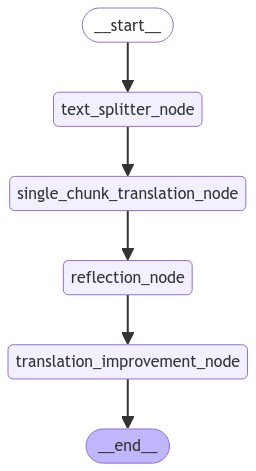

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

## 開始與圖對話

In [ ]:
def run_translation(
      source_lang: str,
      target_lang: str,
      source_text: str,
      country: Optional[str] = None
    ) -> str:
    """
    使用 LangGraph 執行整個翻譯過程。此函數負責執行整個翻譯過程。它創建一個初始的翻譯狀態，然後調用已編譯的翻譯應用程序（app），最後返回最終的翻譯結果。

    參數：
        source_lang (str): 源語言。
        target_lang (str): 目標語言。
        source_text (str): 要翻譯的文本。
        country (Optional[str]): 目標國家，用於本地化（如果適用）。

    返回：
        str: 最終翻譯的文本。
    """

    # 創建初始的翻譯狀態
    initial_state = TranslationState(
        source_lang=source_lang,
        target_lang=target_lang,
        country=country,
        source_text=source_text
    )

    # 調用已編譯的翻譯應用程序，並傳入初始狀態
    final_state = app.invoke(initial_state, debug=False)

    # 返回最終的翻譯結果
    return final_state

### 使用範例ㄧ、英文到西班牙文，在台灣

In [ ]:
# 使用範例
source_lang = "English"
target_lang = "Spanish"
source_text = "Hello, how are you? This is a test of the translation system."
translated_text = run_translation(
    source_lang = source_lang,
    target_lang = target_lang,
    country = "Taiwan",
    source_text = source_text
  )
print(f"Translated text: {translated_text}")

[0:tasks] Starting step 0 with 1 task:
- __start__ -> TranslationState(source_lang='English', target_lang='Spanish', country='Taiwan', source_text='Hello, how are you? This is a test of the translation system.', source_chunks=[], initial_translation=None, initial_translation_chunks=[], reflection=None, reflection_chunks=[], final_translation=None, final_translation_chunks=[])
[0:writes] Finished step 0 with writes to 8 channels:
- source_lang -> 'English'
- target_lang -> 'Spanish'
- country -> 'Taiwan'
- source_text -> 'Hello, how are you? This is a test of the translation system.'
- source_chunks -> []
- initial_translation_chunks -> []
- reflection_chunks -> []
- final_translation_chunks -> []
[1:tasks] Starting step 1 with 1 task:
- text_splitter_node -> TranslationState(source_lang='English', target_lang='Spanish', country='Taiwan', source_text='Hello, how are you? This is a test of the translation system.', source_chunks=[], initial_translation=None, initial_translation_chunks=[]

In [ ]:
translated_text['final_translation']

'Based on the expert suggestions provided, here is an improved translation that considers formality, clarity, naturalness, and appropriate terminology:\n\n**Improved Translation (Spanish):**\n"Hola, ¿cómo está usted? Esto es una prueba del funcionamiento del sistema de traducciones."\n\nThis translation:\n- Uses the formal "usted" to address the reader politely and formally, suitable for professional or respectful contexts.\n- Clarifies that the test is specifically about the "funcionamiento" (operation) of the system, enhancing the specificity and clarity of the original message.\n- Chooses "sistema de traducciones" instead of "sistema de traducción" to sound more natural and specific in Spanish, potentially aligning better with certain dialects and contexts.\n- Preserves the overall fluency and accuracy while tailoring the message to be more appropriate for formal and professional settings.'

### 使用範例二、英文到正體中文


In [ ]:
# 使用範例
source_lang = "English"
target_lang = "Tradiaional Chinese"
source_text = "Hi there. How to get to the Taipei Main Station?"
translated_text = run_translation(
    source_lang = source_lang,
    target_lang = target_lang,
    country = "Taiwan",
    source_text = source_text
  )
print(f"Translated text: {translated_text}")

[0:tasks] Starting step 0 with 1 task:
- __start__ -> TranslationState(source_lang='English', target_lang='Tradiaional Chinese', country='Taiwan', source_text='Hi there. How to get to the Taipei Main Station?', source_chunks=[], initial_translation=None, initial_translation_chunks=[], reflection=None, reflection_chunks=[], final_translation=None, final_translation_chunks=[])
[0:writes] Finished step 0 with writes to 8 channels:
- source_lang -> 'English'
- target_lang -> 'Tradiaional Chinese'
- country -> 'Taiwan'
- source_text -> 'Hi there. How to get to the Taipei Main Station?'
- source_chunks -> []
- initial_translation_chunks -> []
- reflection_chunks -> []
- final_translation_chunks -> []
[1:tasks] Starting step 1 with 1 task:
- text_splitter_node -> TranslationState(source_lang='English', target_lang='Tradiaional Chinese', country='Taiwan', source_text='Hi there. How to get to the Taipei Main Station?', source_chunks=[], initial_translation=None, initial_translation_chunks=[], r

In [ ]:
translated_text['final_translation']

'你好。請問怎麼去台北火車總站？'

### 使用範例三、正體中文到韓文，在台灣

In [ ]:
# 使用範例
source_lang = "Tradiaional Chinese"
target_lang = "Korea"
source_text = "如果您要參加即將活動,您必須先完成任務。"
translated_text = run_translation(
    source_lang = source_lang,
    target_lang = target_lang,
    country = "Taiwan",
    source_text = source_text
  )
print(f"Translated text: {translated_text}")

[0:tasks] Starting step 0 with 1 task:
- __start__ -> TranslationState(source_lang='Tradiaional Chinese', target_lang='Korea', country='Taiwan', source_text='如果您要參加即將活動,您必須先完成任務。', source_chunks=[], initial_translation=None, initial_translation_chunks=[], reflection=None, reflection_chunks=[], final_translation=None, final_translation_chunks=[])
[0:writes] Finished step 0 with writes to 8 channels:
- source_lang -> 'Tradiaional Chinese'
- target_lang -> 'Korea'
- country -> 'Taiwan'
- source_text -> '如果您要參加即將活動,您必須先完成任務。'
- source_chunks -> []
- initial_translation_chunks -> []
- reflection_chunks -> []
- final_translation_chunks -> []
[1:tasks] Starting step 1 with 1 task:
- text_splitter_node -> TranslationState(source_lang='Tradiaional Chinese', target_lang='Korea', country='Taiwan', source_text='如果您要參加即將活動,您必須先完成任務。', source_chunks=[], initial_translation=None, initial_translation_chunks=[], reflection=None, reflection_chunks=[], final_translation=None, final_translation_chunks=[])

In [ ]:
translated_text['final_translation']

'Improved translation (Korean): 곧 있을 행사에 참가하려면 먼저 과제를 완수해야 합니다. 이를 위해 준비해 주시기 바랍니다.'

## 衍伸題目

- 問題1：在 text_splitter_node 函數中，如何改進文本分割的策略以處理不同語言的特定需求？
  - 提示：考慮文本的語言特性，如中文的斷詞、英文的詞組和標點符號等。

- 問題2：single_chunk_translation_node 中使用的提示語句對翻譯結果有何影響？如何改進提示語句以提高翻譯質量？
  - 提示：嘗試不同的提示語句結構，觀察翻譯質量的變化。

- 問題3：在 reflection_node 函數中，如何設計更有效的反思提示，以提供更具建設性的批評和改進建議？
  - 提示：思考如何讓反思提示更具體、更明確，以便語言模型能提供更精確的建議。

- 問題4：translation_improvement_node 函數中，根據反思結果改進翻譯的過程有哪些挑戰？如何進一步優化這個過程？
  - 提示：考慮如何更好地利用反思結果來改進翻譯，並確保最終翻譯的連貫性和一致性。

## Graph 效能分析

通過分析執行數據，我們觀察到各個翻譯節點的性能表現，以及不同語言處理過程中的延遲時間。主要節點包括 text_splitter_node、single_chunk_translation_node、reflection_node 和 translation_improvement_node。

![LangGraph 分析圖](https://imgur.com/RoVHyTE.png)

1. **高效文本分塊：**
 - `text_splitter_node` 節點延遲時間最短，僅為 0.01 秒，顯示出極高的處理效率。
2. **穩定翻譯與改進：**
 - `single_chunk_translation_node` 和 `translation_improvement_node` 節點在不同語言間保持一致的延遲時間，顯示出穩定的性能表現。
3. **優化反思節點：**
 - `reflection_node` 節點延遲時間較長，特別是在繁體中文翻譯過程中，需要進一步優化以提高整體性能。

### 測試完整資料集

透過 GPT-4o 產生多語系轉換結果，藉此衡量所需執行時間。鑑於 LangSmith 免費版只能 trance 500 筆資訊一個月，使用資料及當中前 10 筆資料進行計算。

根據結果平均時間為` 21.38` seconds

#### 測試用程式碼

In [ ]:
import pandas as pd
import requests
from typing import Optional
import time

# 從 URL 讀取 CSV 文件
def read_csv_from_url(url: str, file_path: str) -> pd.DataFrame:
    if os.path.exists(file_path):
        print(f"File {file_path} already exists. Reading from local file.")
        return pd.read_csv(file_path)
    else:
        print(f"File {file_path} does not exist. Downloading from {url}.")
        response = requests.get(url)
        response.raise_for_status()  # 確保請求成功

    with open('temp.csv', 'wb') as file:
        file.write(response.content)
    return pd.read_csv('temp.csv')

# 執行翻譯並列印出結果
def execute_translation_tests(data: pd.DataFrame):
    results = []
    for index, row in data.iterrows():
        if index >= 10:  # 只測試前十筆資料
            break
        source_lang = row['source_lang']
        target_lang = row['target_lang']
        source_text = row['source_text']
        country = row['country']

        # 執行翻譯並計算執行時間
        start_time = time.time()
        translated_text = run_translation(source_lang, target_lang, source_text, country)
        end_time = time.time()
        execution_time = end_time - start_time

        # 執行翻譯
        translated_text = run_translation(source_lang, target_lang, source_text, country)
        results.append({
            'source_lang': source_lang,
            'target_lang': target_lang,
            'source_text': source_text,
            'country': country,
            'translated_text': translated_text,
            'execution_time': execution_time
        })
        print(f"Test {index+1}/10: {source_lang} to {target_lang}")
        print(f"Source: {source_text}")
        print(f"Translation: {translated_text}")
        print(f"Execution time: {execution_time:.2f} seconds\n")

    return results

# 主函數
def main():
    url = 'https://gist.githubusercontent.com/Heng-xiu/0736780e874238630ab239cdb160b6fa/raw/4394cc8075b7f81bc94baa50524a17aabeae72c1/100_GPT4o.csv'
    data = read_csv_from_url(url, 'temp.csv')
    results = execute_translation_tests(data)

    # 將結果保存到新的 CSV 文件中
    results_df = pd.DataFrame(results)
    results_df.to_csv('translation_results.csv', index=False, encoding='utf-8-sig')

#### 執行計算

In [ ]:
main()

File temp.csv already exists. Reading from local file.
[0:tasks] Starting step 0 with 1 task:
- __start__ -> TranslationState(source_lang='Traditional Chinese', target_lang='English', country='Taiwan', source_text='您好，請問有空房嗎？', source_chunks=[], initial_translation=None, initial_translation_chunks=[], reflection=None, reflection_chunks=[], final_translation=None, final_translation_chunks=[])
[0:writes] Finished step 0 with writes to 8 channels:
- source_lang -> 'Traditional Chinese'
- target_lang -> 'English'
- country -> 'Taiwan'
- source_text -> '您好，請問有空房嗎？'
- source_chunks -> []
- initial_translation_chunks -> []
- reflection_chunks -> []
- final_translation_chunks -> []
[1:tasks] Starting step 1 with 1 task:
- text_splitter_node -> TranslationState(source_lang='Traditional Chinese', target_lang='English', country='Taiwan', source_text='您好，請問有空房嗎？', source_chunks=[], initial_translation=None, initial_translation_chunks=[], reflection=None, reflection_chunks=[], final_translation=Non

#### 計算執行時間

In [ ]:
# 計算執行時間的統計數據
def calculate_statistics_from_csv(file_path: str):
    df = pd.read_csv(file_path)
    mean_time = df['execution_time'].mean()
    median_time = df['execution_time'].median()
    return mean_time, median_time

# 從 CSV 文件計算統計數據
mean_time, median_time = calculate_statistics_from_csv('translation_results.csv')
print(f"Average Execution Time: {mean_time:.2f} seconds")
print(f"Median Execution Time: {median_time:.2f} seconds")

Average Execution Time: 21.38 seconds
Median Execution Time: 22.95 seconds
